In [1]:
from torchvision.datasets import CelebA

train = CelebA("data", "train", download=True)
valid = CelebA("data", "valid", download=True)
test = CelebA("data", "test", download=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Number of pictures: 162770
Number of attributes: 40


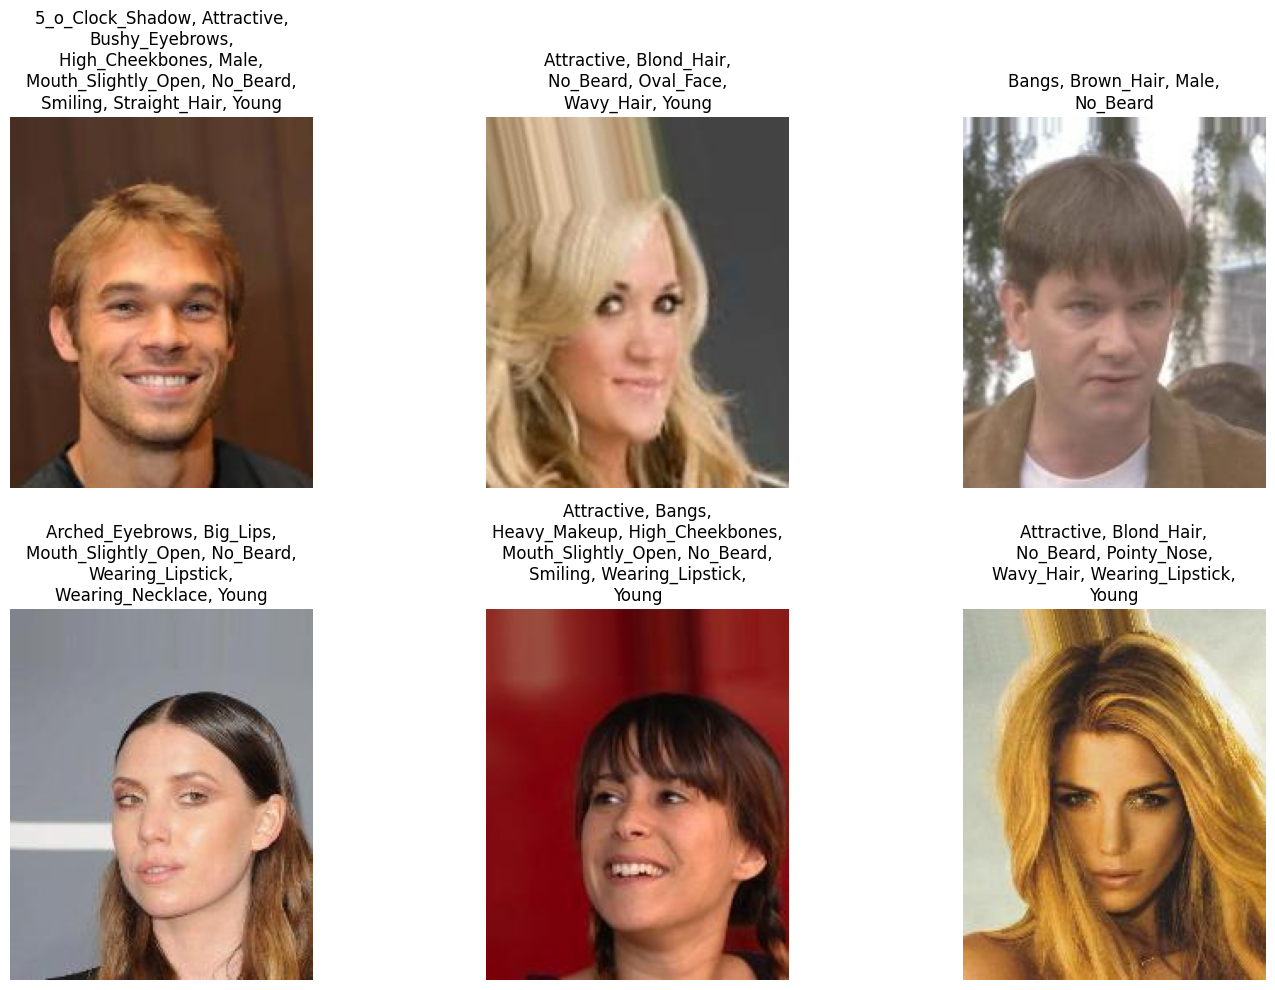

In [2]:
import matplotlib.pyplot as plt
import random
import textwrap

print(f"Number of pictures: {len(train)}")

print(f"Number of attributes: {len(train.attr_names[:-1])}")

# Define the number of rows and columns for the grid of images
ROWS = 2
COLS = 3

# Create subplots
fig, axs = plt.subplots(ROWS, COLS, figsize=(5*COLS, 5*ROWS))

# Randomly select images
selected_images = random.sample(range(len(train)), ROWS * COLS)

for i in range(ROWS * COLS):
    # Get attributes for the current image
    attrs = [attr for j, attr in enumerate(train.attr_names[:-1]) if train[selected_images[i]][1][j] == 1]
    
    # Calculate the row and column indices for the current image
    row = i // COLS
    col = i % COLS
    
    # Display the image
    axs[row, col].imshow(train[selected_images[i]][0])

    # Remove the axes
    axs[row, col].axis('off')
    
    # Set the title to the attributes, with line breaks
    title = ", ".join(attrs)
    axs[row, col].set_title(textwrap.fill(title, 30))

# Remove empty subplots
if ROWS * COLS > len(train):
    for i in range(len(train), ROWS * COLS):
        row = i // COLS
        col = i % COLS
        fig.delaxes(axs[row][col])

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
from efficientformer_v3 import EfficientFormerV3
from torchvision.transforms import ToTensor

model = EfficientFormerV3()

example = ToTensor()(train[0][0]).unsqueeze(0)
model.forward(example)

tensor([[[[-0.0325, -0.1660, -0.1660,  ...,  0.1461, -0.1568, -0.1565],
          [-0.1547, -0.1678, -0.1678,  ..., -0.1244, -0.1646, -0.1662],
          [-0.1547, -0.1678, -0.1678,  ..., -0.1483, -0.1513, -0.1604],
          ...,
          [-0.1394, -0.1696,  0.8043,  ...,  0.4952,  0.5026, -0.1698],
          [-0.1349, -0.1113,  1.0312,  ...,  0.6525,  0.7913, -0.0457],
          [-0.1288,  0.0512,  0.8464,  ...,  0.2078,  0.2387, -0.1159]],

         [[ 2.2560, -0.1292, -0.1292,  ..., -0.1330,  0.4394, -0.1023],
          [ 1.3666, -0.1128, -0.1128,  ..., -0.1422,  2.2837, -0.1197],
          [ 1.3666, -0.1128, -0.1128,  ...,  0.9734, -0.1647, -0.0931],
          ...,
          [ 0.0065, -0.0954,  1.0580,  ...,  0.1227, -0.1619, -0.1356],
          [ 0.8467,  2.0406, -0.0045,  ...,  0.1535,  0.1367,  0.0434],
          [ 0.5067, -0.0734,  0.2112,  ...,  0.4008,  0.2279,  0.1209]],

         [[-0.1425, -0.0665, -0.0665,  ..., -0.1452, -0.1386, -0.0116],
          [-0.1698,  1.0255,  

In [13]:
import torch
import torchvision

@torch.no_grad()
def trace(model, example):
    model.eval()
    return torch.jit.trace(model, example)
traced_model = trace(model, example)
out = traced_model(example)

import coremltools as ct


# Using image_input in the inputs parameter:
# Convert to Core ML program using the Unified Conversion API.
model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.TensorType(shape=example.shape)]
 )

# Save the converted model.
model.save("newmodel.mlpackage")

Model is not in eval mode. Consider calling '.eval()' on your model prior to conversion
Running MIL default pipeline:   0%|          | 0/71 [00:00<?, ? passes/s]/Users/cyanosite/Development/Facial-Attribute-Recognition/.venv/lib/python3.11/site-packages/coremltools/converters/mil/mil/passes/defs/preprocess.py:267: UserWarning: Output, '45', of the source model, has been renamed to 'var_45' in the Core ML model.
  warnings.warn(msg.format(var.name, new_name))
Running MIL backend_mlprogram pipeline: 100%|██████████| 12/12 [00:00<00:00, 10407.70 passes/s]
